In [2]:
import pandas as pd # for data analytics
import numpy as np # for numerical computation
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

%matplotlib inline

In [3]:

dataset = pd.read_csv('creditcard.csv')

In [4]:
dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)
normal = dataset[dataset['Class'] == 0]

anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(284315, 31)
(492, 31)


In [5]:

from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

('Train shape: ', (227452, 31))
Proportion os anomaly in training set: 0.00

('Valid shape: ', (28677, 31))
Proportion os anomaly in validation set: 0.01

('Test shape:, ', (28678, 31))
Proportion os anomaly in test set: 0.01



Gaussian Model Based

In this technique, we assume that the data comes from a Gaussian distribution. We can fit such a Gaussian using simple Maximum Likelihood Estimates (MLE). Then, the distance from the mean in standard deviations is the anomaly score for an data instance:
zz=|xx−x¯x¯|ss

Where ( \pmb{\bar{x}} ) is the sample mean and ( \pmb{s} ) is the sample variance. We can use a validation set to find an optimal threshold for the score, above which we will consider the instance an anomaly. This is equivalent to finding a hypersphere where the center is the sample mean and the radius is determined by the threshold. Data points outside this sphere will be classified as anomalous. One drawback of this technique is that it does not account for relationships among variables. More technically, this model assumes that that each feature in the data is linear independent from one another and that probabilities of the data can be decomposed as follows
P(XX)=P(x1x1)∗P(x2x2)∗...∗P(xdxd)

This would not be a problem if all our variables where principal components extracted from PCA, since they would be linear independent, but as this is not the case, we better account for correlation among features. To do that, we simply use the use the Mahalanobis distance of a test instance ( \pmb{x} ) to the sample mean ( \pmb{\bar{x}} ). So that this score reflects a valid probability distribution, we will fit a full covariance matrix multi-variate normal distribution to the data:
P(xx)ˆ=1(2π)d∗detSS−1‾‾‾‾‾‾‾‾‾‾‾‾‾‾√∗exp(−12∗(xx−x¯x¯)TSS−1(xx−x¯x¯))

were ( \pmb{S} ) is the sample covariance matrix. This fix the problem of assuming linear independence.

In [ ]:
from scipy.stats import multivariate_normal

mu = train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values


In [ ]:

model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)


print(np.median(model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 


In [ ]:


tresholds = np.linspace(-1000,-10, 150)
scores = []
for treshold in tresholds :
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])


In [ ]:
scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())


In [ ]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.cluster import KMeans
gmm = KMeans(n_clusters=3)
gmm.fit(train.drop('Class', axis=1).values)

In [ ]:
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

In [ ]:


tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())


In [ ]:


class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        
        bin_hight, bin_edge = [], []
        
        for var in X.T:
            # get bins hight and interval
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)
        
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)
   

    def predict(self, X):
        
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                
                # find wich bin obs is in
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num]) # find bin hitght
            
            scores.append(np.mean(obs_score))
        
        return np.array(scores)
                

        
model = hist_model()
model.fit(train.drop('Class', axis=1).values)
print(np.median(model.predict(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.predict(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 



In [ ]:
train['V10'].values

In [ ]:
model.fit(train['V10'].values)

In [ ]:
from sklearn.svm import OneClassSVM
np.random.seed(42)

model = OneClassSVM(gamma=0.000562, nu=.95, kernel='rbf')
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())


In [ ]:
tresholds = np.linspace(-50000, -400, 500)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []

# Auto Encoders 

Neural based techniques

In recent years, unsupervised deep learning has taken the knowledge frontier in machine learning research. Many believe that by learning a good representation of the data we will be able to make our supervised models generalize better. This lead to a huge increase in unsupervised deep learning research and many algorithms are rapidly emerging. Here, we will use a well know and not so new approach of a replicating neural network named the autoencoder. In this technique, a multilayer perceptron with the same number of input and output neurons is trained with maximum likelihood to replicate the input data. To avoid simply learning the identity function, we use a bottleneck layer, with fewer neurons than the input size, thus forcing the network to compress the input in its internal representation.

If we use only normal data to train the network, we can hope it will learn a good internal representation of it and thus have a low reconstruction error wen asked to replicate normal data. Moreover, as it have never seen how the anomalous data looks like, we also hope that the network will do a poor job reconstructing the anomalies. Hence, we can use the reconstruction error, ( (\pmb{\tilde{x}} - \pmb{x})^2 ), as an anomaly score. Is the error is too large, we can then flag the instance as an anomaly.

Below, build an autoencoder with a bottleneck layer of only 2 neurons.

In [6]:
import tensorflow as tf
tf.reset_default_graph()
tf.set_random_seed(2)

In [7]:
train.shape

(227452, 31)

In [27]:
batch_size =10000
n_visible = train.drop('Class', axis=1).values.shape[1]
n_hidden1 = 27
n_hidden2 = 16
n_hidden3 = 2

In [9]:
learning_rate = 0.01
# create node for input data
X_tf = tf.placeholder("float",[None,n_visible],name = 'X')


In [13]:
# Paramtetrs initialization
W1_init = 4 * np.sqrt(6. / (n_visible + n_hidden1))
W2_init = 4 * np.sqrt(6. / (n_hidden1 + n_hidden2))
W3_init = 4 * np.sqrt(6. / (n_hidden2 + n_hidden3))

In [31]:
W1 =  tf.Variable(tf.random_uniform([n_visible,n_hidden1],minval=-W1_init, maxval=W1_init), name='W1')
b1 = tf.Variable(tf.zeros([n_hidden1]),name = 'b1')

W2 = tf.Variable(tf.random_uniform([n_hidden1,n_hidden2],minval= -W2_init, maxval= W2_init), name ='W2')
b2= tf.Variable(tf.zeros([n_hidden2]), name='b2')

W3 = tf.Variable(tf.random_uniform([n_hidden2,n_hidden3],minval= -W3_init,maxval=W3_init),name='W3')
b3 = tf.Variable(tf.zeros([n_hidden3]),name = 'b3')

W3_prime = tf.Variable(tf.random_uniform([n_hidden3, n_hidden2],
                                   minval=-W3_init, maxval=W3_init), name='W3_prime')  
b3_prime = tf.Variable(tf.zeros([n_hidden2]), name='b3_prime')

W2_prime = tf.Variable(tf.random_uniform([n_hidden2, n_hidden1],
                                   minval=-W2_init, maxval=W2_init), name='W2_prime')  
b2_prime = tf.Variable(tf.zeros([n_hidden1]), name='b2_prime')

W1_prime =  tf.Variable(tf.random_uniform([n_hidden1, n_visible],
                                   minval=-W1_init, maxval=W1_init), name='W1_prime')
b1_prime = tf.Variable(tf.zeros([n_visible]), name='b1_prime')

def autoencoder(X_tf):
    #encoder
      #y = Wx +b
        Y = tf.nn.tanh(tf.add(tf.matmul(X_tf,W1),b1))
        Y = tf.nn.tanh(tf.add(tf.matmul(Y,W2),b2))
        Y = tf.nn.tanh(tf.add(tf.matmul(Y,W3),b3))

      # decoder
        Z = tf.nn.tanh(tf.matmul(Y, W3_prime) + b3_prime)
        Z = tf.nn.tanh(tf.matmul(Z, W2_prime) + b2_prime)  
        Z = tf.nn.tanh(tf.matmul(Z, W1_prime) + b1_prime)
    
        return Z, Y
Z, Y = autoencoder(X_tf)
cost= tf.reduce_mean(tf.pow(X_tf- Z,2))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
scores = tf.abs(X_tf - Z)


In [21]:
X_train = train.drop('Class', axis=1).values
X_val_norm = valid[valid['Class'] == 0].drop('Class', axis=1).values
X_val_anorm = valid[valid['Class'] == 1].drop('Class', axis=1).values


In [35]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for step in range (15001):
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]

        sess.run(train_op, feed_dict={X_tf: batch_data,})
        
        if (step % 3000 == 0):
            print('\nBatch loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: batch_data})))
            print('Val Norm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_norm})))
            print('Val Anorm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_anorm})))
        
    y_scores_valid, enc_val = sess.run([scores, Y], feed_dict={X_tf: valid.drop('Class', axis=1).values})
    y_scores_test, enc_test = sess.run([scores, Y], feed_dict={X_tf: test.drop('Class', axis=1).values})
        


Batch loss at step 0: 6.257528
Val Norm loss at step 0: 6.289206
Val Anorm loss at step 0: 31.363935

Batch loss at step 3000: 4.527044
Val Norm loss at step 3000: 4.514933
Val Anorm loss at step 3000: 26.980848

Batch loss at step 6000: 4.499721
Val Norm loss at step 6000: 4.492274
Val Anorm loss at step 6000: 27.128784

Batch loss at step 9000: 4.464999
Val Norm loss at step 9000: 4.478693
Val Anorm loss at step 9000: 27.065798

Batch loss at step 12000: 4.424628
Val Norm loss at step 12000: 4.462211
Val Anorm loss at step 12000: 27.049500

Batch loss at step 15000: 4.377654
Val Norm loss at step 15000: 4.439326
Val Anorm loss at step 15000: 26.788778


In [36]:
print (y_scores_valid.mean(axis=1))

[ 0.99142635  1.08707058  0.76594144 ...,  0.80795825  0.72226983
  0.96377939]


In [38]:
t =y_scores_valid.mean(axis=1)

In [40]:
t.max()

23.500706

In [41]:
t.min()

0.29956239

In [42]:
t.mean()

0.90483105

In [43]:
t.std()

0.41431177

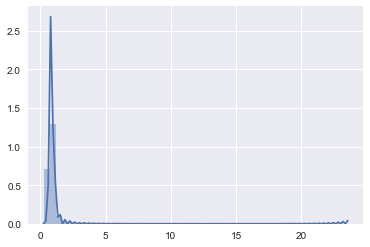

In [44]:
sns.distplot(t)

In [45]:
tresholds = np.linspace(0, 6, 100)

scores = []
for treshold in tresholds:
    y_hat = (y_scores_valid.mean(axis=1) > treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

(0.56286549707602329, 35)


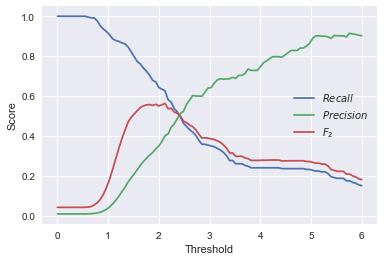

In [46]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()